# Models

## Table of Contents
- Load Data
- Sample and Feature Preparation
    - Missing Data
    - One-Hot Encoding
    - Label Encoding
    - Output Encoding
- Train-Test Split
- Utils
- Model Selection
    - RandomForest
        - Hyperparameter Tuning
        - Correlation Between Models
        - Pairwise Comparison of Models
        - Final Model Evaluation
    - LightGBM
        - Hyperparameter Tuning
        - Correlation Between Models
        - Pairwise Comparison of Models
        - Final Model Evaluation
- Final Model
    - Final Model
    - Metrics
    - Model Analysis
    - Feature Importance

In [1]:
import joblib
from copy import deepcopy
from itertools import combinations
import random
from math import factorial
from scipy import stats
from scipy.stats import t
import numpy as np
import pandas as pd

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# utils
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# models
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
) 
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# sns config
sns.set_style("whitegrid")
sns.set_palette("Blues_r")

In [3]:
# plotly config
import plotly.io as pio
pio.renderers.default = "browser"

template = "plotly_white"
colors = {
    "red": "rgb(255,0,0)",
    "dark_blue": "rgb(30,144,255)",
    "medium_blue": "rgb(0,191,255)",
    "light_blue": "rgb(135,206,250)",
    "dark_purple": "rgb(202, 105, 157)",
    "medium_purple": "rgb(221, 136, 172)",
    "light_purple": "rgb(234, 169, 189)",
    "dark_gray": "rgb(169,169,169)",
    "medium_gray": "rgb(192,192,192)",
    "light_gray": "rgb(211,211,211)"
}
title_font_size = 22
font_size = 18

# Load Data

**Note:**
- Keep only features that have predictive value based on the Data Analysis.
- Keep only features that are present during inference time, e.g. loan statistics are discarded.

In [4]:
ftrs = ['id', 'user_id', 'created_at', 'loan_term', 'amount_cat', 'loan_fees_bin', 'interest_rate_bin', 'loan_quality']

df_loans_train = pd.read_pickle("../data/interim/df_loans_train_raw.pkl")
df_loans_train = df_loans_train[ftrs]

df_loans_test = pd.read_pickle("../data/interim/df_loans_test_raw.pkl")
df_loans_test = df_loans_test[ftrs]

df_loans_train

,id,user_id,created_at,loan_term,amount_cat,loan_fees_bin,interest_rate_bin,loan_quality
0,86,1,2022-02-02,90,large,40 - 50,small,bad_loan
2,1744,3,2022-04-18,91,large,40 - 50,small,good_loan
5,6428,4,2022-09-19,90,large,40 - 50,large,bad_loan
6,2222,5,2022-04-22,90,large,40 - 50,small,good_loan
7,3380,5,2022-05-27,90,large,40 - 50,small,good_loan
...,...,...,...,...,...,...,...,...
6583,1186,3153,2022-03-15,90,large,40 - 50,small,good_loan
6584,3111,3153,2022-05-04,90,large,40 - 50,small,bad_loan
6585,3856,3153,2022-06-15,90,large,40 - 50,small,good_loan
6586,4358,3153,2022-07-04,90,large,40 - 50,small,good_loan


In [5]:
ftrs = ['user_id', 'median_intallments', 'rate_denied', 'rate_transactions_installment', 'rate_credit_debit',
        'ratio_online_person', 'rate_default', 'median_repayment_amount', 'max_repayment_delay', 
        'rate_due_date_exceeded', 'rate_late_repayment', 'rate_manual_auto_repayments', 'rate_repaid_loans']

df_users = pd.read_pickle("../data/processed/df_users.pkl")
df_users = df_users[ftrs]

df_users["rate_transactions_installment"] = df_users["rate_transactions_installment"].astype(float)

df_users

,user_id,median_intallments,rate_denied,rate_transactions_installment,rate_credit_debit,ratio_online_person,rate_default,median_repayment_amount,max_repayment_delay,rate_due_date_exceeded,rate_late_repayment,rate_manual_auto_repayments,rate_repaid_loans
0,1,2.0,0.300000,0.700000,5.000000,0.090909,0.000000,39.0000,0.0,0.000000,0.000000,0.500000,0.000
1,2,10.0,0.057143,0.971429,17.500000,0.027778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5.0,0.115385,1.000000,79.000000,0.025641,0.052632,270.0000,0.0,0.000000,0.000000,0.105263,1.000
3,4,1.0,0.090909,0.419580,1.666667,0.006993,0.074074,169.5000,0.0,0.000000,0.000000,0.115385,1.000
4,5,1.0,0.083228,0.480454,131.500000,0.001259,0.012658,122.3200,0.0,0.000000,0.000000,0.051948,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3038,3149,1.0,0.069264,0.333333,2.065789,0.008658,0.000000,40.8000,8.0,1.000000,0.066667,0.062500,0.000
3039,3150,1.0,0.174323,0.398115,2.590717,0.291351,0.054795,217.1850,10.0,0.250000,0.013699,0.129771,0.875
3040,3151,2.0,0.092511,0.568282,2.271429,0.022321,0.014493,87.5625,1.0,0.500000,0.014493,0.028986,1.000
3041,3152,3.0,0.135063,0.952594,61.222222,0.029412,0.016949,110.5750,0.0,0.000000,0.000000,0.022857,1.000


In [6]:
df_users_segments = pd.read_pickle("../data/processed/df_users_segments.pkl")

df_users_segments

,user_id,rfm_segment_desc
0,1,Inactive
1,2,Inactive
2,3,Inactive
3,4,Promising
4,5,Promising
...,...,...
3038,3149,Inactive
3039,3150,Champions
3040,3151,Inactive
3041,3152,Promising


# Sample and Feature Preparation

- Missing Data
- One-Hot Encoding
- Output Encoding

In [7]:
# merge tables
df_users = df_users.merge(df_users_segments, how="left", on="user_id")

df_train = df_loans_train.merge(df_users, how="left", on="user_id").rename(columns={"id": "loan_id"})
# during merging the statistics of the existing users in trainset are transfered to the testset (no impute needed)
# missing statistics for new users w/ and w/o transaction history needs impute (solved in the following section)
df_test = df_loans_test.merge(df_users, how="left", on="user_id").rename(columns={"id": "loan_id"})

In [8]:
# sort by loan_id and repayment date (ascending)
df_train = df_train.sort_values(by=["user_id", "created_at"])
df_test = df_test.sort_values(by=["user_id", "created_at"])

In [9]:
# df_data = df_data.drop(columns=["created_at", "user_id"]) 

## Missing Data

**Note:**
- **New users w/ transaction history**
    - New users for which we have the transaction history, have already been assigned to an RFM customer segment.
    - Loan repayment behavioral statistics for these users are calculated according to the behavior of the RFM segment that they belong to.
- **New users w/o transaction history**
    - New users for which we don't have yet the transaction history, are assigned to the RFM customer segment `Recent`.
    - Purchase and loan repayment behavioral statistics for these users are calculated according to the behavior of the RFM segment `Recent`. 

In [10]:
ftrs = ["median_intallments", "rate_denied", "rate_transactions_installment", "rate_credit_debit",
        "ratio_online_person", "rate_default", "median_repayment_amount", "max_repayment_delay", 
        "rate_due_date_exceeded", "rate_late_repayment", "rate_manual_auto_repayments", "rate_repaid_loans"]

segments = ['Inactive', 'Promising', 'Big Spenders', 'Champions', 'Recent']

In [11]:
# new users being evaluated are assigned to the RFM customer segment Recent
df_train.loc[df_train["rfm_segment_desc"].isna(), "rfm_segment_desc"] = "Recent"

# train contains new users
# these have been assigned as Recent customers
# missing values are calculated based on the Recent customers' behavior
for ftr in ftrs:
    df_train.loc[df_train[ftr].isna(), ftr] = df_train[df_train["rfm_segment_desc"] == "Recent"][ftr].median()

In [12]:
# new users being evaluated are assigned to the RFM customer segment Recent
new_users_id = set(df_test[df_test["rfm_segment_desc"].isna()]["user_id"])
df_test.loc[df_test["rfm_segment_desc"].isna(), "rfm_segment_desc"] = "Recent"

# test contains new users (no transaction history)
# new users have been assigned as Recent customers 
# missing values are calculated based on the Recent customers' behavior
for ftr in ftrs:
    df_test.loc[(df_test[ftr].isna()) & (df_test["user_id"].isin(new_users_id)), ftr] = df_train[df_train["rfm_segment_desc"] == "Recent"][ftr].median()

# test contains new users (transaction history exists)
# missing values are calculated based on the customer segment that a user belongs to
for ftr in ftrs:
    for segment in segments:
        median_segment_value = df_train[df_train["rfm_segment_desc"] == segment][ftr].median()
        df_test.loc[(df_test[ftr].isna()) & (df_test["rfm_segment_desc"] == segment), ftr] = median_segment_value

## One-Hot Encoding

In [13]:
df_train = pd.concat([df_train, pd.get_dummies(df_train["rfm_segment_desc"], prefix="rfm_segment")], axis=1)
df_train = df_train.drop(["rfm_segment_desc"], axis=1)

In [14]:
df_test = pd.concat([df_test, pd.get_dummies(df_test["rfm_segment_desc"], prefix="rfm_segment")], axis=1)
df_test = df_test.drop(["rfm_segment_desc"], axis=1)

## Label Encoding

In [15]:
mapping = {
    "small": 1,
    "medium": 2,
    "large": 3,
}
df_train["amount_cat"], df_test["amount_cat"] = df_train["amount_cat"].replace(mapping), df_test["amount_cat"].replace(mapping)
df_train["interest_rate_bin"], df_test["interest_rate_bin"] = df_train["interest_rate_bin"].replace(mapping), df_test["interest_rate_bin"].replace(mapping)

mapping = {
    '0 - 10': 1,
    '10 - 20': 2,
    '20 - 30': 3,
    '30 - 40': 4,
    '40 - 50': 5,   
}
df_train["loan_fees_bin"], df_test["loan_fees_bin"] = df_train["loan_fees_bin"].replace(mapping), df_test["loan_fees_bin"].replace(mapping)

## Output Encoding

In [16]:
mapping = {
    "bad_loan": 0,
    "good_loan": 1,
}
df_train["loan_quality"] = df_train["loan_quality"].replace(mapping)
df_test["loan_quality"] = df_test["loan_quality"].replace(mapping)

# Utils

In [17]:
def multi_time_series_split(
    df: pd.DataFrame, 
    primary_key: str, 
    test_size_frac: float, 
    stratify_key: str, 
    random_state: int,
) -> tuple:
    """ Split multiple time-series data into train and test subsets.

    Test set contains the newest records of each time-series.

    Args:
        df:
            Input datataset.
        primary_key:
            Feature that distinguishes the time-series.
        test_size_frac:
            Proportion of the dataset to include in the test split.
        stratify_key:
            Feature to split in a stratified fashion.
        random_state:
            Controls the shuffling applied to the data before applying the split.
    
    Returns:
        Train and test set features and target.
    """
    test_size = round(df.shape[0] * test_size_frac)
    
    df_slice = df.groupby(primary_key, as_index=False).last()

    _, test = train_test_split(df_slice, test_size=test_size, stratify=df_slice[stratify_key], random_state=random_state)

    X_train, X_test = df[~df.index.isin(test.index)], df[df.index.isin(test.index)]
    
    return X_train, X_test

# Train-Test Split

**Note:** Train-Test splitting is available in `preprocessing_feature_engineering.ipynb`

In [18]:
print(f"Train: number of loans: {df_train['loan_id'].unique().shape[0]:,}\nTest: number of loans: {df_test['loan_id'].unique().shape[0]:,}")

Train: number of loans: 5,270
Test: number of loans: 1,318


In [19]:
good_loan, bad_loan = df_train[df_train["loan_quality"] == 1].shape[0], df_train[df_train["loan_quality"] == 0].shape[0]
print(f"Train:\n\tnumber of good loans: {good_loan:,}\n\tnumber of bad loans: {bad_loan:,}")

good_loan, bad_loan = df_test[df_test["loan_quality"] == 1].shape[0], df_test[df_test["loan_quality"] == 0].shape[0]
print(f"Test:\n\tnumber of good loans: {good_loan:,}\n\tnumber of bad loans: {bad_loan:,}")

Train:
	number of good loans: 3,008
	number of bad loans: 2,262
Test:
	number of good loans: 760
	number of bad loans: 558


In [20]:
# sort by user and date of loan to get latest loan in eval set per user
df_train_t = df_train.sort_values(by=["user_id", "created_at"])

# single_loan flag is used for stratification purposes
# it is important to have in the test set user with only 1 loan because these will be evaluated as new users
# meaning that information related to their lending habits will be erased
df_temp = df_train_t.groupby("user_id", as_index=False)["loan_id"].count().rename(columns={"loan_id": "num_loans"})
df_train_t = df_train_t.merge(df_temp, how="left", on="user_id")
df_train_t["single_loan"] = (df_train_t["num_loans"] == 1)

df_loans_train_t, df_loans_eval = multi_time_series_split(df_train_t, primary_key="user_id", test_size_frac=.2, stratify_key="single_loan", random_state=42)

In [21]:
print(f"Train: number of loans: {df_loans_train_t['loan_id'].unique().shape[0]:,}\nEval: number of loans: {df_loans_eval['loan_id'].unique().shape[0]:,}")

Train: number of loans: 4,216
Eval: number of loans: 1,054


In [22]:
good_loan, bad_loan = df_loans_train_t[df_loans_train_t["loan_quality"] == 1].shape[0], df_loans_train_t[df_loans_train_t["loan_quality"] == 0].shape[0]
print(f"Train:\n\tnumber of good loans: {good_loan:,}\n\tnumber of bad loans: {bad_loan:,}")

good_loan, bad_loan = df_loans_eval[df_loans_eval["loan_quality"] == 1].shape[0], df_loans_eval[df_loans_eval["loan_quality"] == 0].shape[0]
print(f"Eval:\n\tnumber of good loans: {good_loan:,}\n\tnumber of bad loans: {bad_loan:,}")

Train:
	number of good loans: 2,400
	number of bad loans: 1,816
Eval:
	number of good loans: 608
	number of bad loans: 446


In [23]:
X_train = df_train.loc[:, ~df_train.columns.isin(['loan_id', 'user_id', 'created_at', 'loan_quality'])]
y_train = df_train.loc[:, df_train.columns == 'loan_quality']
X_test = df_test.loc[:, ~df_test.columns.isin(['loan_id', 'user_id', 'created_at', 'loan_quality'])]
y_test = df_test.loc[:, df_test.columns == 'loan_quality']

X_train_t = df_loans_train_t.loc[:, ~df_loans_train_t.columns.isin(['loan_id', 'user_id', 'created_at', 'loan_quality'])]
y_train_t = df_loans_train_t.loc[:, df_loans_train_t.columns == 'loan_quality']
X_eval = df_loans_eval.loc[:, ~df_loans_eval.columns.isin(['loan_id', 'user_id', 'created_at', 'loan_quality'])]
y_eval = df_loans_eval.loc[:, df_loans_eval.columns == 'loan_quality']

# Utils

In [24]:
def corrected_std(differences, n_train, n_test):
    """ Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters:
        differences:
            Vector containing the differences in the score metrics of two models.
        n_train:
            Number of samples in the training set.
        n_test:
            Number of samples in the testing set.

    Returns:
        corrected_std:
            Variance-corrected standard deviation of the set of differences.
    """
    kr = len(differences)  # number of times the model was evaluated
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

In [25]:
def compute_corrected_ttest(differences, df, n_train, n_test):
    """ Computes right-tailed paired t-test with corrected variance.

    Parameters:
        differences:
            Vector containing the differences in the score metrics of two models.
        df:
            Degrees of freedom.
        n_train:
            Number of samples in the training set.
        n_test:
            Number of samples in the testing set.

    Returns:
        t_stat:
            Variance-corrected t-statistic.
        p_val:
            Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [26]:
cv = KFold(n_splits=10)

# Model Selection

In [27]:
labels = ["bad candidate", "good candidate"]

## Random Forest

### Hyperparameter Tuning

---

**Best search parameters:** n_estimators: 150, max_depth: 15, class_weight: balanced

In [28]:
pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# hyperparameter space
parameters = {
    'clf__n_estimators': list(range(50, 550, 50)),
    'clf__max_depth': list(range(5, 55, 5)) + [None],
    'clf__class_weight': ["balanced", "balanced_subsample"]
}

In [ ]:
# hyperparameter tuning
search = BayesSearchCV(
    pipe,
    parameters,
    n_iter=60,
    scoring=["f1_weighted", "precision_weighted", "recall_weighted"],
    refit="f1_weighted",
    cv=cv,
    return_train_score=True,
    random_state=42,
    verbose=10
)

search.fit(X_train_t, np.ravel(y_train_t))

In [30]:
print(f'Best search train weighted F1-score: {search.cv_results_["mean_train_f1_weighted"][search.best_index_]:,.2f}')
print(f'Best search eval weighted F1-score: {search.cv_results_["mean_test_f1_weighted"][search.best_index_]:,.2f}\n')

print(f'Best search train weighted Precision: {search.cv_results_["mean_train_precision_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Precision: {search.cv_results_["mean_test_precision_weighted"][search.best_index_]:.2f}\n')

print(f'Best search train weighted Recall: {search.cv_results_["mean_train_recall_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Recall: {search.cv_results_["mean_test_recall_weighted"][search.best_index_]:.2f}\n')

print(f'Best search parameters:\n{search.best_params_}')

Best search train weighted F1-score: 0.91
Best search eval weighted F1-score: 0.84

Best search train weighted Precision: 0.91
Best search eval weighted Precision: 0.84

Best search train weighted Recall: 0.91
Best search eval weighted Recall: 0.84

Best search parameters:
OrderedDict([('clf__class_weight', 'balanced'), ('clf__max_depth', 15), ('clf__n_estimators', 150)])


### Correlation Between Models

We can observe tha **tthe performance of the models highly depends on the fold**.

As a consequence, if we assume independence between samples we will be underestimating the variance computed in our statistical tests, increasing the number of false positive errors (i.e. detecting a significant difference between models when such does not exist)

In [31]:
df_results = pd.DataFrame(search.cv_results_).sort_values(by=["rank_test_f1_weighted"])
df_results = df_results.set_index(
    df_results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("iter")
df_results[["params", "rank_test_f1_weighted", "mean_train_f1_weighted", "mean_test_f1_weighted", 
            "rank_test_precision_weighted", "mean_train_precision_weighted", "mean_test_precision_weighted", 
            "rank_test_recall_weighted", "mean_train_recall_weighted", "mean_test_recall_weighted"]].head(3)

,params,rank_test_f1_weighted,mean_train_f1_weighted,mean_test_f1_weighted,rank_test_precision_weighted,mean_train_precision_weighted,mean_test_precision_weighted,rank_test_recall_weighted,mean_train_recall_weighted,mean_test_recall_weighted
iter,,,,,,,,,,
balanced_15_150,"{'clf__class_weight': 'balanced', 'clf__max_de...",1,0.912299,0.842695,1,0.912671,0.844796,1,0.912555,0.843917
balanced_15_350,"{'clf__class_weight': 'balanced', 'clf__max_de...",2,0.912614,0.841896,4,0.912837,0.844079,3,0.912819,0.843205
balanced_15_450,"{'clf__class_weight': 'balanced', 'clf__max_de...",3,0.912951,0.841874,3,0.913122,0.844164,2,0.913135,0.843205


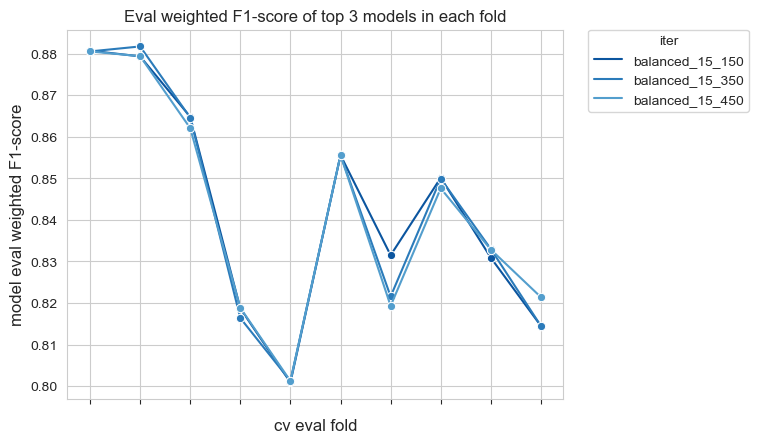

In [32]:
# model scores ordered by performance
model_f1 = df_results.filter(regex=r"split\d*_test_f1_weighted").iloc[:3]

fig, ax = plt.subplots()

sns.lineplot(
    data=model_f1.transpose(),
    dashes=False,
    marker="o",
    ax=ax,
)

ax.set_title('Eval weighted F1-score of top 3 models in each fold')
ax.set_xlabel("cv eval fold", size=12, labelpad=10)
ax.set_ylabel("model eval weighted F1-score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.legend(title='iter', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [33]:
# correlation of weighted F1-score across folds
print(f"Correlation of models based on weighted F1-score:\n")
model_f1.transpose().corr()

Correlation of models based on weighted F1-score:



iter,balanced_15_150,balanced_15_350,balanced_15_450
iter,,,
balanced_15_150,1.000000,0.993091,0.984799
balanced_15_350,0.993091,1.000000,0.995716
balanced_15_450,0.984799,0.995716,1.000000


### Pairwise Comparison of Models

[Frequentist Approach](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#): Run a paired t-test and compute the p-value.

We observe that, although the models don't significantly differ from each other, the proposed model from hyperaparameter tuning is the recommended one.

In [34]:
# pairwise comparison of models based on weighted F1-score

n_train = len(list(cv.split(X_train_t, y_train_t))[0][0])
n_test = len(list(cv.split(X_train_t, y_train_t))[0][1])

n_comparisons = factorial(len(model_f1)) / (factorial(2) * factorial(len(model_f1) - 2))
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_f1)), 2):
    model_i_scores = model_f1.iloc[model_i].values
    model_k_scores = model_f1.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    n = differences.shape[0]  # number of test sets
    df = n - 1
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # Bonferroni correction
    p_val = 1 if p_val > 1 else p_val  # Bonferroni can output p-values higher than 1
    pairwise_t_test.append([model_f1.index[model_i], model_f1.index[model_k], t_stat, p_val])

pairwise_comp_df = pd.DataFrame(pairwise_t_test, 
                                columns=["model_1", "model_2", "t_stat", "p_val"]).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,balanced_15_150,balanced_15_350,0.503,0.941
1,balanced_15_150,balanced_15_450,0.372,1.000
2,balanced_15_350,balanced_15_450,0.016,1.000


### Final Model Evaluation

---

**Best model parameters:**  n_estimators: 150, max_depth: 15, class_weight: balanced

---

**Best model train weighted F1-score:** 91%
- class good_candidate: 92%
- class bad_candidate: 89%

**Best model eval weighted F1-score:** 80%
- class good_candidate: 83%
- class bad_candidate: 76%

---

**Best model train weighted Precision:** 91%
- class good_candidate: 91%
- class bad_candidate: 92%

**Best model eval weighted Precision:** 80%
- class good_candidate: 82%
- class bad_candidate: 78%

---

**Best model train weighted Recall:** 91%
- class good_candidate: 94%
- class bad_candidate: 87%

**Best model eval weighted Recall:** 80%
- class good_candidate: 85%
- class bad_candidate: 74%

---

**Conclusion:** The model is somewhat certain when it encounters bad candidates (74% Precision) and can somewhat distinguish the bad candidates (74% Recall).  

In [38]:
clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    class_weight= 'balanced',
    random_state=42
)

clf.fit(X_train_t, np.ravel(y_train_t))

y_train_pred = clf.predict(X_train_t)
y_eval_pred = clf.predict(X_eval)

In [39]:
print(f"Train:\n{classification_report(y_train_t, y_train_pred, target_names=labels)}")
print(f"Eval:\n{classification_report(y_eval, y_eval_pred, target_names=labels)}")

Train:
                precision    recall  f1-score   support

 bad candidate       0.92      0.87      0.89      1816
good candidate       0.91      0.94      0.92      2400

      accuracy                           0.91      4216
     macro avg       0.91      0.91      0.91      4216
  weighted avg       0.91      0.91      0.91      4216

Eval:
                precision    recall  f1-score   support

 bad candidate       0.78      0.74      0.76       446
good candidate       0.82      0.85      0.83       608

      accuracy                           0.80      1054
     macro avg       0.80      0.79      0.80      1054
  weighted avg       0.80      0.80      0.80      1054



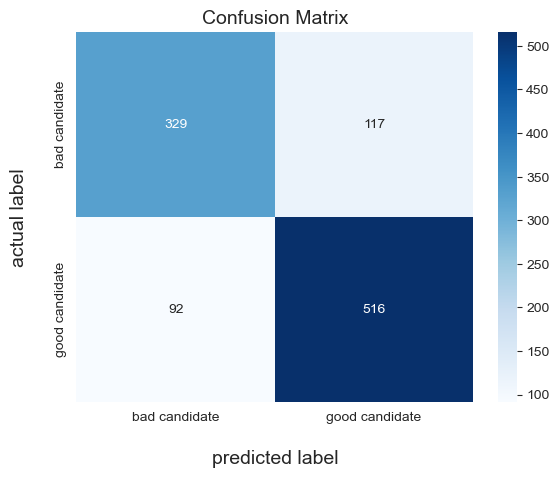

In [40]:
cm = confusion_matrix(y_eval, y_eval_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

## LightGBM

### Hyperparameter Tuning

---

**Best search parameters:** n_estimators: 100, max_depth: 15, learning_rate: 0.1, colsample_bytree: 0.4, booster: gbdt, class_weight: 'balanced'

In [41]:
pipe = Pipeline([
    ('clf', LGBMClassifier(class_weight="balanced", random_state=42))
])

# hyperparameter space
parameters = {
    'clf__n_estimators': list(range(50, 550, 50)),
    'clf__max_depth': list(range(5, 55, 5)),
    'clf__colsample_bytree': [.4, .5, .6, .8, 1],
    'clf__learning_rate': [1, 1e-1, 1e-2, 1e-3],
    'clf__boosting_type': ['gbdt', 'dart']
}

In [ ]:
# hyperparameter tuning
search = BayesSearchCV(
    pipe,
    parameters,
    n_iter=60,
    scoring=["f1_weighted", "precision_weighted", "recall_weighted"],
    refit="f1_weighted",
    cv=cv,
    return_train_score=True,
    random_state=42,
    verbose=10
)

search.fit(X_train_t, np.ravel(y_train_t))

In [43]:
print(f'Best search train weighted F1-score: {search.cv_results_["mean_train_f1_weighted"][search.best_index_]:,.2f}')
print(f'Best search eval weighted F1-score: {search.cv_results_["mean_test_f1_weighted"][search.best_index_]:,.2f}\n')

print(f'Best search train weighted Precision: {search.cv_results_["mean_train_precision_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Precision: {search.cv_results_["mean_test_precision_weighted"][search.best_index_]:.2f}\n')

print(f'Best search train weighted Recall: {search.cv_results_["mean_train_recall_weighted"][search.best_index_]:.2f}')
print(f'Best search eval weighted Recall: {search.cv_results_["mean_test_recall_weighted"][search.best_index_]:.2f}\n')

print(f'Best search parameters:\n{search.best_params_}')

Best search train weighted F1-score: 0.89
Best search eval weighted F1-score: 0.84

Best search train weighted Precision: 0.89
Best search eval weighted Precision: 0.84

Best search train weighted Recall: 0.89
Best search eval weighted Recall: 0.84

Best search parameters:
OrderedDict([('clf__boosting_type', 'gbdt'), ('clf__colsample_bytree', 0.4), ('clf__learning_rate', 0.1), ('clf__max_depth', 15), ('clf__n_estimators', 100)])


### Correlation Between Models

We can observe tha **tthe performance of the models highly depends on the fold**.

As a consequence, if we assume independence between samples we will be underestimating the variance computed in our statistical tests, increasing the number of false positive errors (i.e. detecting a significant difference between models when such does not exist)

In [44]:
df_results = pd.DataFrame(search.cv_results_).sort_values(by=["rank_test_f1_weighted"])
df_results = df_results.set_index(
    df_results["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("iter")
df_results[["params", "rank_test_f1_weighted", "mean_train_f1_weighted", "mean_test_f1_weighted", 
            "rank_test_precision_weighted", "mean_train_precision_weighted", "mean_test_precision_weighted", 
            "rank_test_recall_weighted", "mean_train_recall_weighted", "mean_test_recall_weighted"]].head(3)

,params,rank_test_f1_weighted,mean_train_f1_weighted,mean_test_f1_weighted,rank_test_precision_weighted,mean_train_precision_weighted,mean_test_precision_weighted,rank_test_recall_weighted,mean_train_recall_weighted,mean_test_recall_weighted
iter,,,,,,,,,,
gbdt_0.4_0.1_15_100,"{'clf__boosting_type': 'gbdt', 'clf__colsample...",1,0.889971,0.841123,3,0.889965,0.841873,1,0.890075,0.841784
dart_0.6_0.1_5_250,"{'clf__boosting_type': 'dart', 'clf__colsample...",2,0.868818,0.841041,2,0.868899,0.842132,2,0.869096,0.841543
dart_0.8_0.1_5_350,"{'clf__boosting_type': 'dart', 'clf__colsample...",3,0.871497,0.841039,1,0.871574,0.842161,3,0.871758,0.841541


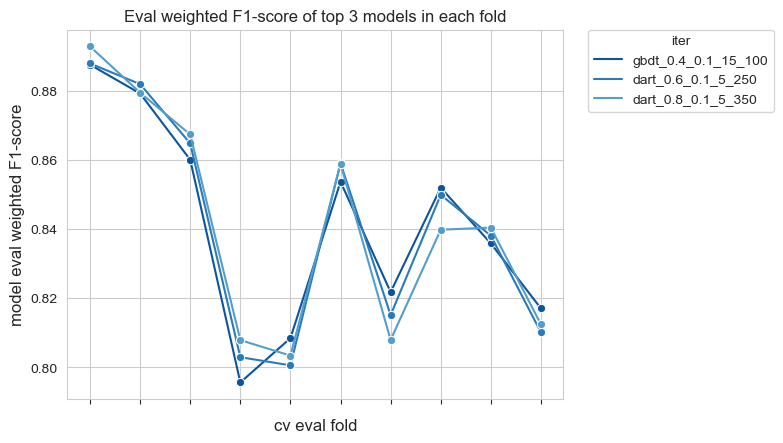

In [45]:
# model scores ordered by performance
model_f1 = df_results.filter(regex=r"split\d*_test_f1_weighted").iloc[:3]

fig, ax = plt.subplots()

sns.lineplot(
    data=model_f1.transpose(),
    dashes=False,
    marker="o",
    ax=ax,
)

ax.set_title('Eval weighted F1-score of top 3 models in each fold')
ax.set_xlabel("cv eval fold", size=12, labelpad=10)
ax.set_ylabel("model eval weighted F1-score", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.legend(title='iter', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [46]:
# correlation of weighted F1-score across folds
print(f"Correlation of models based on weighted F1-score:\n")
model_f1.transpose().corr()

Correlation of models based on weighted F1-score:



iter,gbdt_0.4_0.1_15_100,dart_0.6_0.1_5_250,dart_0.8_0.1_5_350
iter,,,
gbdt_0.4_0.1_15_100,1.000000,0.986860,0.965277
dart_0.6_0.1_5_250,0.986860,1.000000,0.987807
dart_0.8_0.1_5_350,0.965277,0.987807,1.000000


### Pairwise Comparison of Models

[Frequentist Approach](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#): Run a paired t-test and compute the p-value.

We observe that the models **don't significantly differ** from each other, thus we can select the proposed model from hyperaparameter tuning.

In [47]:
# pairwise comparison of models based on weighted F1-score

n_train = len(list(cv.split(X_train_t, y_train_t))[0][0])
n_test = len(list(cv.split(X_train_t, y_train_t))[0][1])

n_comparisons = factorial(len(model_f1)) / (factorial(2) * factorial(len(model_f1) - 2))
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_f1)), 2):
    model_i_scores = model_f1.iloc[model_i].values
    model_k_scores = model_f1.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    n = differences.shape[0]  # number of test sets
    df = n - 1
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # Bonferroni correction
    p_val = 1 if p_val > 1 else p_val  # Bonferroni can output p-values higher than 1
    pairwise_t_test.append([model_f1.index[model_i], model_f1.index[model_k], t_stat, p_val])

pairwise_comp_df = pd.DataFrame(pairwise_t_test, 
                                columns=["model_1", "model_2", "t_stat", "p_val"]).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,gbdt_0.4_0.1_15_100,dart_0.6_0.1_5_250,0.032,1
1,gbdt_0.4_0.1_15_100,dart_0.8_0.1_5_350,0.021,1
2,dart_0.6_0.1_5_250,dart_0.8_0.1_5_350,0.001,1


### Final Model Evaluation

---

**Best model parameters:** n_estimators: 100, max_depth: 15, learning_rate: 0.1, colsample_bytree: 0.4, booster: gbdt, class_weight: 'balanced'

---

**Best model train weighted F1-score:** 89%
- class good_candidate: 90%
- class bad_candidate: 87%

**Best model eval weighted F1-score:** 82%
- class good_candidate: 85%
- class bad_candidate: 78%

---

**Best model train weighted Precision:** 89%
- class good_candidate: 90%
- class bad_candidate: 87%

**Best model eval weighted Precision:** 82%
- class good_candidate: 83%
- class bad_candidate: 80%

---

**Best model train weighted Recall:** 89%
- class good_candidate: 91%
- class bad_candidate: 86%

**Best model eval weighted Recall:** 82%
- class good_candidate: 86%
- class bad_candidate: 76%

---

**Conclusion:** The model is fairly certain when it encounters bad candidates (80% Precision) but cannot fully distinguish all bad candidates (78% Recall).  

In [ ]:
clf = LGBMClassifier(
    n_estimators=100,
    max_depth=15,
    learning_rate=0.1,
    colsample_bytree=0.4,
    boosting_type='gbdt',
    class_weight="balanced",
    random_state=42
)

clf.fit(X_train_t, np.ravel(y_train_t))

y_train_pred = clf.predict(X_train_t)
y_eval_pred = clf.predict(X_eval)

In [52]:
print(f"Train:\n{classification_report(y_train_t, y_train_pred, target_names=labels)}")
print(f"Eval:\n{classification_report(y_eval, y_eval_pred, target_names=labels)}")

Train:
                precision    recall  f1-score   support

 bad candidate       0.87      0.86      0.87      1816
good candidate       0.90      0.91      0.90      2400

      accuracy                           0.89      4216
     macro avg       0.88      0.88      0.88      4216
  weighted avg       0.89      0.89      0.89      4216

Eval:
                precision    recall  f1-score   support

 bad candidate       0.80      0.76      0.78       446
good candidate       0.83      0.86      0.85       608

      accuracy                           0.82      1054
     macro avg       0.82      0.81      0.81      1054
  weighted avg       0.82      0.82      0.82      1054



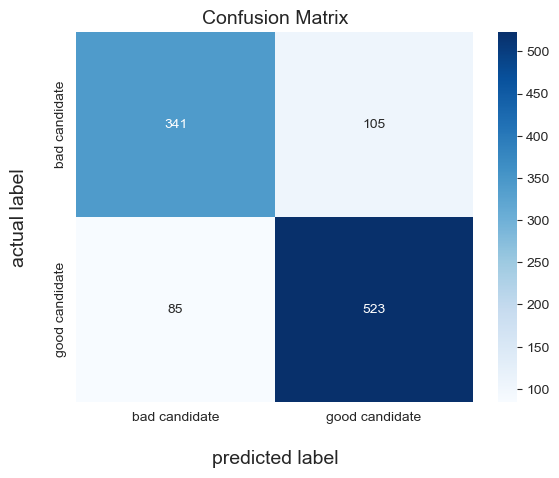

In [53]:
cm = confusion_matrix(y_eval, y_eval_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

# Final Model

In [28]:
labels = ["bad candidate", "good candidate"]

## Final Model

---

**Model:** LightGBM

**Parameters:** n_estimators: 100, max_depth: 15, learning_rate: 0.1, colsample_bytree: 0.4, booster: 'gbdt', class_weight: 'balanced'

*The final model has been chosen based on the best weighted F1-score, Precision and Recall on the evaluation sample. Also, the degree of overfittng (or underfitting) has been taken into consideration.*

In [ ]:
clf = LGBMClassifier(
    n_estimators=100,
    max_depth=15,
    learning_rate=0.1,
    colsample_bytree=0.4,
    boosting_type='gbdt',
    class_weight="balanced",
    random_state=42
)

clf.fit(X_train, np.ravel(y_train))

y_train_pred, y_train_pred_proba = clf.predict(X_train), clf.predict_proba(X_train)
y_test_pred, y_test_pred_proba = clf.predict(X_test), clf.predict_proba(X_test)

## Metrics

---

**Train weighted F1-score:** 88%
- class good_candidate: 89%
- class bad_candidate: 86%

**Test weighted F1-score:** 65%
- class good_candidate: 70%
- class bad_candidate: 57%

---

**Train weighted Precision**: 88%
- class good_candidate: 89%
- class bad_candidate: 86%

**Test weighted Precision:** 65%
- class good_candidate: 69%
- class bad_candidate: 59%

---

**Train weighted Recall**: 88%
- class good_candidate: 90%
- class bad_candidate: 85%

**Test weighted Recall:** 65%
- class good_candidate: 72%
- class bad_candidate: 56%

---
**Conclusion:** The model is to a certain degree certain when it encounters bad candidates (60% Precision) and cannot fully distinguish all bad candidates (56% Recall).  

In [30]:
print(f"Train:\n{classification_report(y_train, y_train_pred, target_names=labels)}")
print(f"Test:\n{classification_report(y_test, y_test_pred, target_names=labels)}")

Train:
                precision    recall  f1-score   support

 bad candidate       0.86      0.85      0.86      2262
good candidate       0.89      0.90      0.89      3008

      accuracy                           0.88      5270
     macro avg       0.88      0.87      0.87      5270
  weighted avg       0.88      0.88      0.88      5270

Test:
                precision    recall  f1-score   support

 bad candidate       0.59      0.56      0.57       558
good candidate       0.69      0.72      0.70       760

      accuracy                           0.65      1318
     macro avg       0.64      0.64      0.64      1318
  weighted avg       0.65      0.65      0.65      1318



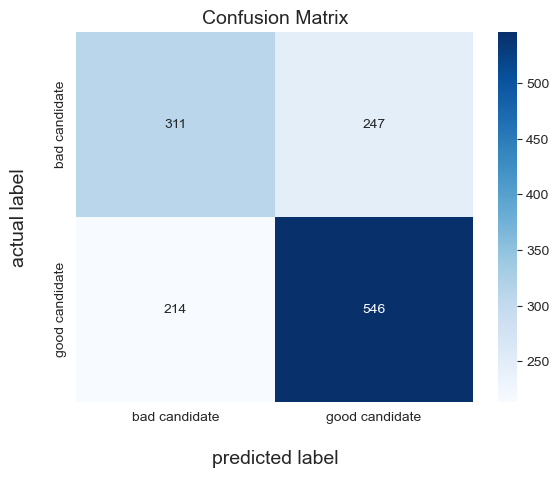

In [31]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel("\npredicted label", fontsize=14)
plt.ylabel("actual label\n", fontsize=14)

plt.show()

## Model Analysis

We define clusters (groups) of loan repayments based on important variables for which we need to provide "accurate" prediction (derived by business needs). These clusters (groups) are based on: 
- principal loan amount
- loan interest rate
- RFM customer segments
- default rate
 
For those cluster, we observe the following:
- Inability to model repayment behavioral patterns for small to medium loan amounts
- The model mainly mispredicts for medium to large loan interest rates
- Inability to bridge the segments' purchasing behavior with repayment behavioral patterns
- Inability to model repayment behavioral mostly for users with small to medium default rates

In [32]:
# reproduce the train and test set to include the loan and user ids
X_train, y_train = df_train.loc[:, ~df_train.columns.isin(['created_at', 'loan_quality'])], df_train.loc[:, df_train.columns == 'loan_quality']
X_test, y_test = df_test.loc[:, ~df_test.columns.isin(['created_at', 'loan_quality'])], df_test.loc[:, df_test.columns == 'loan_quality']

# temp dataframe with test set (1) features, (2) ground truth and (3) prediction
temp_data_test = pd.concat([X_test, y_test], axis=1)
temp_data_test["prediction"] = y_test_pred.tolist()

# aux column marking correct/incorrect predictions
temp_data_test["correct"] = temp_data_test["prediction"] == temp_data_test["loan_quality"]
temp_data_test["correct"] = temp_data_test["correct"].replace({True: "correct", False: "incorrect"})

temp_data_test = temp_data_test[temp_data_test["loan_quality"] == 0]

In [34]:
# reverse one-hot encoding
rfm_segments = ["rfm_segment_Big Spenders", "rfm_segment_Champions", "rfm_segment_Inactive", "rfm_segment_Promising", "rfm_segment_Recent"]
temp_data_test["rfm_segments"] = pd.from_dummies(temp_data_test[rfm_segments])
temp_data_test["rfm_segments"] = temp_data_test["rfm_segments"].replace({
    "rfm_segment_Big Spenders": "Big Spenders", 
    "rfm_segment_Champions": "Champions",
    "rfm_segment_Inactive": "Inactive", 
    "rfm_segment_Promising": "Promising", 
    "rfm_segment_Recent": "Recent"
})

# calculate the percentage of correct/incorrect instances per RFM segment
df = temp_data_test.groupby(["rfm_segments"], as_index=False)["correct"].value_counts()
aux = df.groupby("rfm_segments", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["rfm_segments"].unique():
    df.loc[df["rfm_segments"] == i, "pct"] = df[df["rfm_segments"] == i]["count"].values / aux[aux["rfm_segments"] == i]["count"].values

fig = px.bar(
    df, 
    y='rfm_segments', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text="<b>Inability to bridge the segments' purchasing behavior with repayment behavioral patterns<br><sub>bad candidates in test set</sub><b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of instances',
    yaxis_title_text="customer segments",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_yaxes(
    categoryorder='array', 
    categoryarray=["Inactive", "Recent", "Promising", "Big Spenders", "Champions"]
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

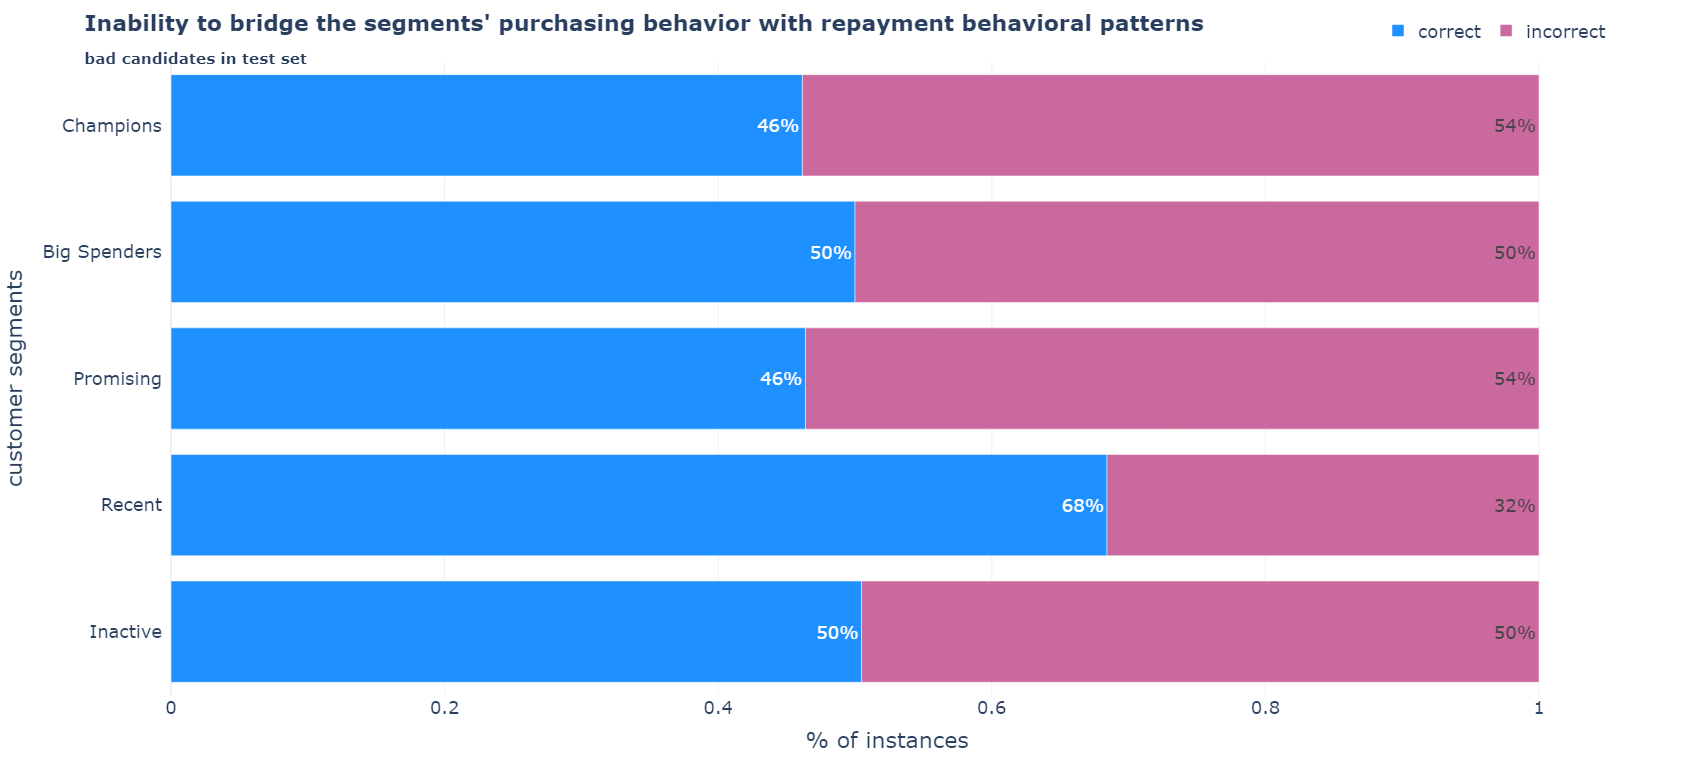

In [46]:
# reverse label encoding
temp_data_test["interest_rate_bin"] = temp_data_test["interest_rate_bin"].replace({
    1: "small", 
    2: "medium",
    3: "large", 
})

# calculate the percentage of correct/incorrect instances per interest rate bin
df = temp_data_test.groupby(["interest_rate_bin"], as_index=False)["correct"].value_counts()
aux = df.groupby("interest_rate_bin", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["interest_rate_bin"].unique():
    df.loc[df["interest_rate_bin"] == i, "pct"] = df[df["interest_rate_bin"] == i]["count"].values / aux[aux["interest_rate_bin"] == i]["count"].values

fig = px.bar(
    df.sort_values(by=["correct"]), 
    y='interest_rate_bin', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>The model mainly mispredicts for medium to large loan interest rates<br><sub>bad candidates in test set</sub><b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of instances',
    yaxis_title_text="loan intereset rate",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

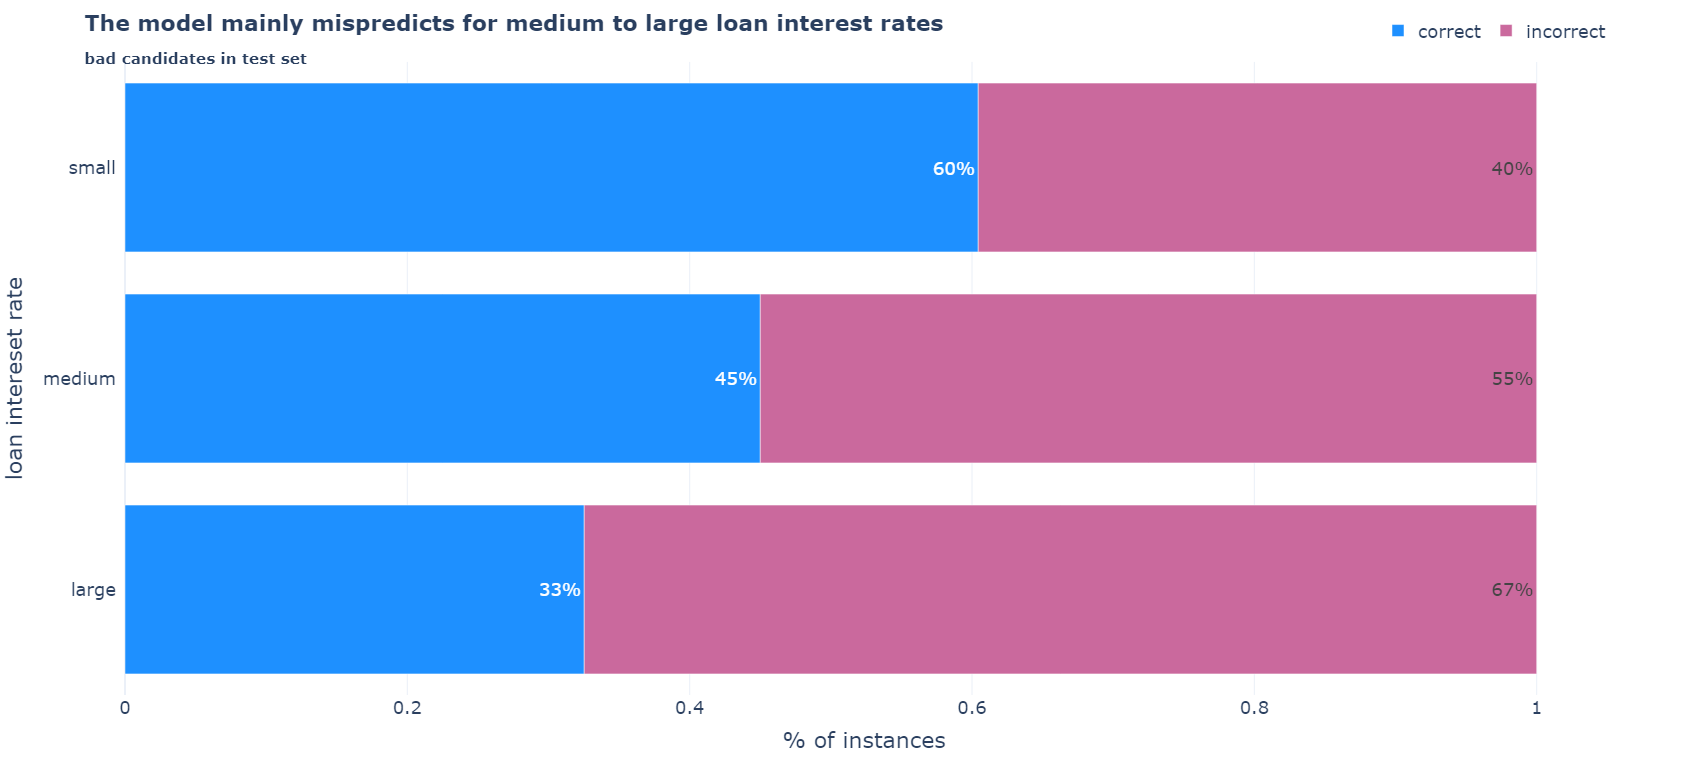

In [49]:
# reverse label encoding
temp_data_test["amount_cat"] = temp_data_test["amount_cat"].replace({
    1: "small", 
    2: "medium",
    3: "large", 
})

# calculate the percentage of correct/incorrect instances per interest rate bin
df = temp_data_test.groupby(["amount_cat"], as_index=False)["correct"].value_counts()
aux = df.groupby("amount_cat", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["amount_cat"].unique():
    df.loc[df["amount_cat"] == i, "pct"] = df[df["amount_cat"] == i]["count"].values / aux[aux["amount_cat"] == i]["count"].values

fig = px.bar(
    df.sort_values(by=["correct"]), 
    y='amount_cat', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>Inability to model repayment behavioral patterns for small to medium loan amounts<br><sub>bad candidates in test set</sub><b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of instances',
    yaxis_title_text="principal loan amount",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

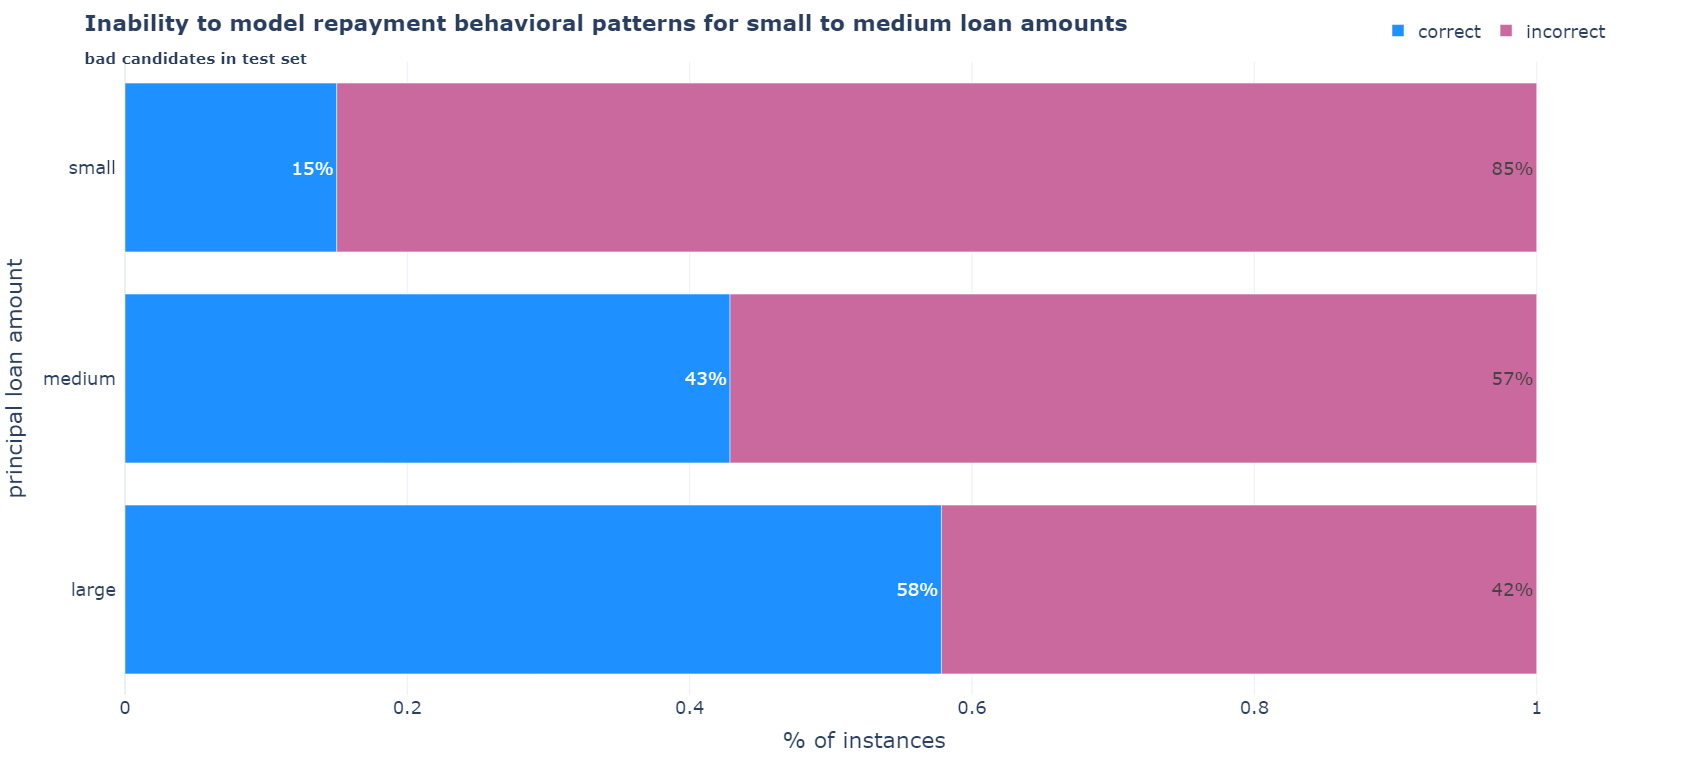

In [65]:
temp_data_test.loc[temp_data_test["rate_default"].between(.02, .05, inclusive='both'), "rate_default_cat"] = "small"
temp_data_test.loc[temp_data_test["rate_default"].between(.05, .1, inclusive='right'), "rate_default_cat"] = "medium"
temp_data_test.loc[temp_data_test["rate_default"] > .1, "rate_default_cat"] = "large"

# calculate the percentage of correct/incorrect instances per interest rate bin
df = temp_data_test.groupby(["rate_default_cat"], as_index=False)["correct"].value_counts()
aux = df.groupby("rate_default_cat", as_index=False)["count"].sum()
df["pct"] = 0
for i in df["rate_default_cat"].unique():
    df.loc[df["rate_default_cat"] == i, "pct"] = df[df["rate_default_cat"] == i]["count"].values / aux[aux["rate_default_cat"] == i]["count"].values

fig = px.bar(
    df.sort_values(by=["correct"]), 
    y='rate_default_cat', 
    x='pct', 
    color="correct",
    orientation="h",
    color_discrete_sequence=[colors["dark_blue"], colors["dark_purple"]]
)

fig.update_layout(
    title_text='<b>Inability to model repayment behavioral mostly for users with small to medium default rates<br><sub>bad candidates in test set</sub><b>',
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title_text='% of instances',
    yaxis_title_text="default rate",
    legend=dict(
        title=None,
        traceorder="normal",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0
    ),
    template=template
)
fig.update_traces(
    texttemplate='%{x:,.0%}',
    textposition='inside'
)

fig.show()

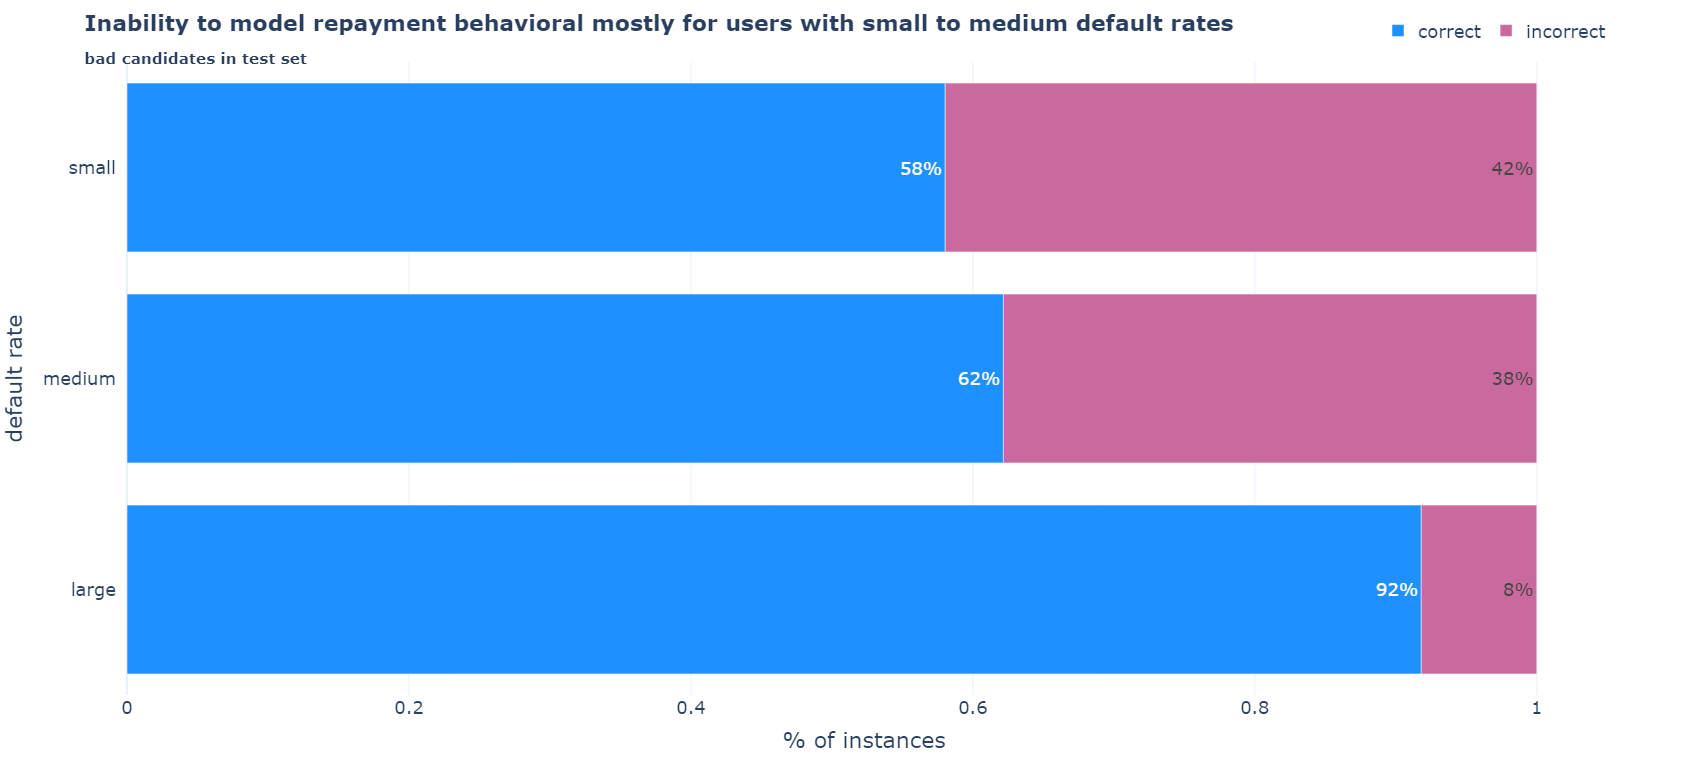

## Feature Importance

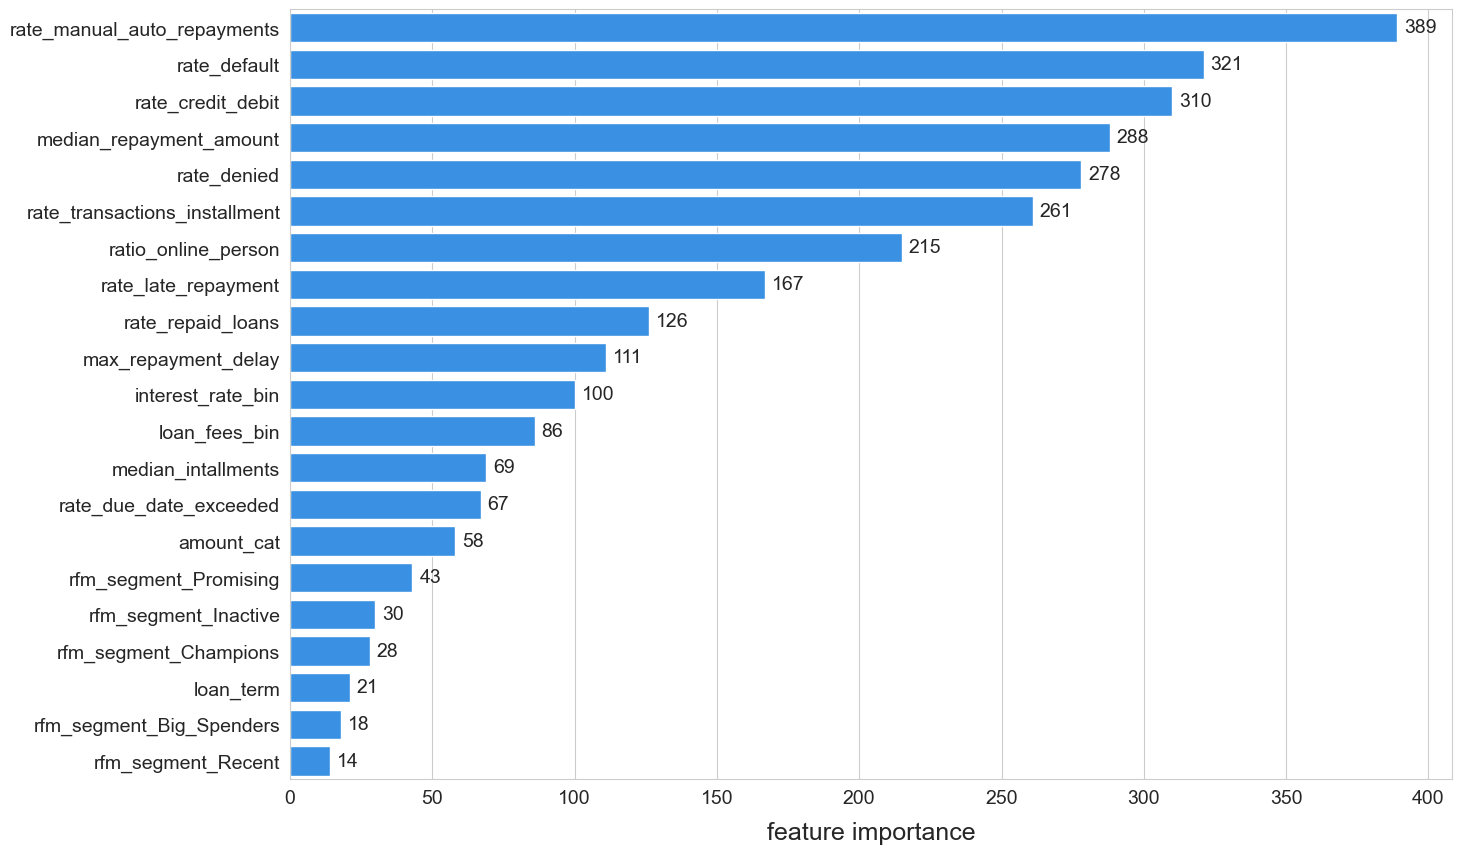

In [67]:
feature_importances = pd.DataFrame(list(zip(clf.feature_name_, clf.feature_importances_)),
                                   columns=['feature', 'importance'])
feature_importances = feature_importances.sort_values(by=['importance'], ascending=False)

fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=feature_importances["importance"], y=feature_importances["feature"], color='#1E90FF')

ax.set_xlabel("feature importance", fontsize=font_size, labelpad=10)
ax.set_ylabel(None)
ax.tick_params(labelsize=14)
ax.bar_label(ax.containers[0], padding=5, fontsize=14)

plt.show()